# Image Segmentation Using DL

Survey  
https://arxiv.org/pdf/2001.05566.pdf  
Panoptic segmentation  
https://arxiv.org/pdf/1801.00868.pdf

## Image segmentaion


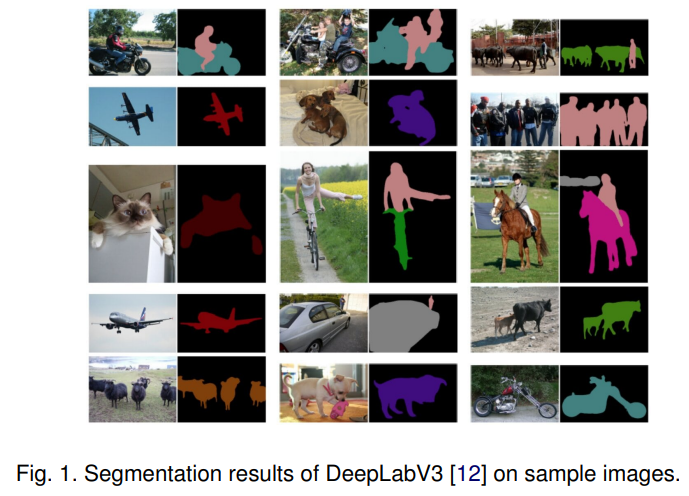

Image segmentation은 이미지를 object별로 분할하는 task이고 visual understanding system에서 중요한 역할을 함.  

이전부터 image segmentation algorithm 들은 계속 연구해왔으며, 딥러닝 모델을 통해 더욱 더 발전함.  

Image segmentation은 Image 의 각 픽셀에 대응되는 label을 예측하는 일종의 분류 문제로 볼 수 있음.  

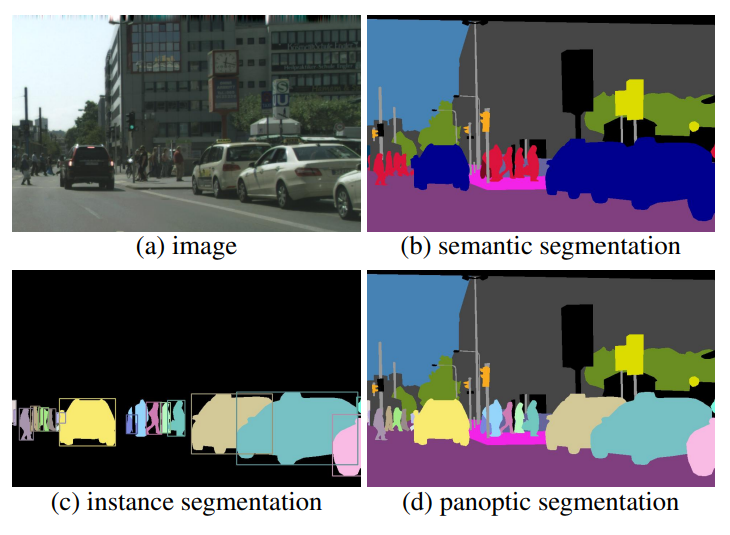

Image segmentation은 크게 두 가지로 나눌 수 있다.  
**Semantic segmentaion** : 각 픽셀마다 대응되는 label을 예측히여 class를 부여    
**Instance segmentation** : object 끼리는 구분이 되지만(intance label) class를 부여하진 않음  

추가로 Panoptic segmentation 은 위의 두 개 task 를 하나로 합친 것

## Segmentation models

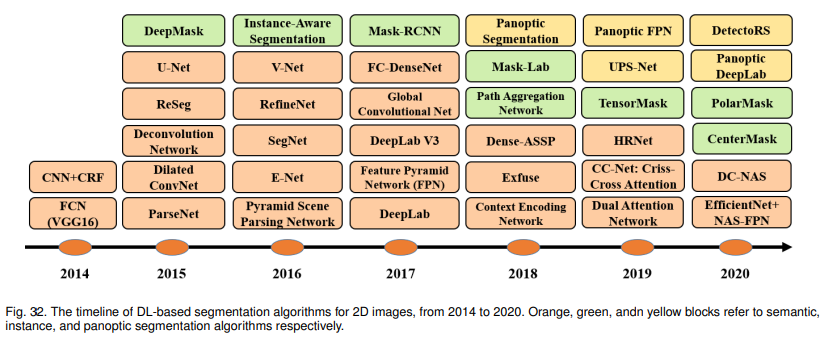

Fully Convolutional Networks(FCN)을 시작으로 하여 다양한 구조와 방법들을 연구함.  

아래와 같이 모델 구조로 나눠 볼 수 있음  

1) Fully convolutional networks  
2) Convolutional models with graphical models  
3) Encoder-decoder based models  
4) Multi-scale and pyramid network based models  
5) R-CNN based models (for instance segmentation)  
6) Dilated convolutional models and DeepLab family  
7) Recurrent neural network based models  
8) Attention-based models  
9) Generative models and adversarial training  
10) Convolutional models with active contour models  
11) Other models  


## Datasets & Metrics

### *Datasets*

Image segmentation 에서는 data augmentation 을 통해 labeled sample 의 수를 늘리는 것이 중요함.  

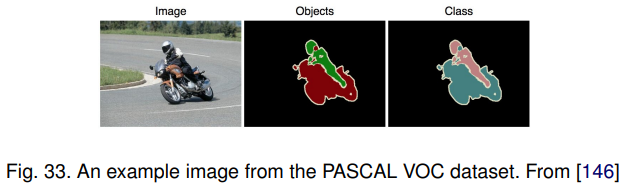

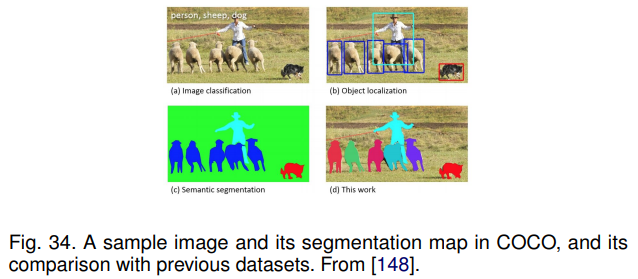

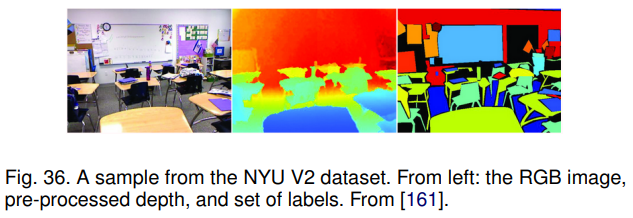

**Some typical transformations** :  
translation, reflection, rotation, warping, scaling, color space shifting,  
cropping, projections onto principal components.  

대표적으로 사용되는 Dataset은 PASCAL Visual Object Classes, MS COCO 등이 있으며,  
2D Dataset 이외에 2.5D(RGB-D), 3D등 task 에 맞는 dataset 이 존재함  

### *Metrics*

model 은 다양한 측면에서 평가되어야 한다.  
quantitative accuracy, inference time, storage requirement 등등  

model accuracy 평가 지표  

**Pixel Accuracy (PA)**
$$ PA = \frac{Σ^K_{i=0}p_{ii}}{Σ^K_{i=0}Σ^K_{j=0}p_{ij}} $$  

**Mean Pixel Accuracy (MPA)**
$$ MPA = Σ^K_{i=0} \frac{p_{ii}}{Σ^K_{j=0}p_{ij}} $$

**Intersection over Union (IoU)**  
$$ IoU = \frac{|A \cap B|}{|A ∪ B|} $$  

**Precision/Recall/F1 score**  
$$ Precision = \frac{TP}{TP + FP} $$
$$ Recall = \frac{TP}{TP + FN} $$
$$ F1 \space score = \frac{2Prec \space Rec}{Prec + Rec} $$

**Dice coefficient**  
metric for image segmentation (commonly used in medical image analysis)  
$$ Dice = \frac{2|A \cap B|}{|A|+|B|} $$


# LAB

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision.datasets as datasets
from torchvision import transforms
from torchvision.utils import make_grid

import os
import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

### U-net

In [ ]:
img_size = 128
batch_size = 128

dataset = datasets.OxfordIIITPet('./', download=True,
                                 split='trainval', target_types='segmentation',
                                 transform = transforms.Compose([transforms.Resize(img_size),
                                                                 transforms.CenterCrop(img_size),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize([0.5,0.5,0.5,],
                                                                                      [0.5,0.5,0.5,])]),
                                 target_transform = transforms.Compose([transforms.Resize(img_size),
                                                                        transforms.CenterCrop(img_size),
                                                                        transforms.Lambda(lambda x : torch.tensor(np.array(x))-1 )]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

100%|██████████| 791918971/791918971 [00:54<00:00, 14439078.67it/s]


Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:02<00:00, 7747132.07it/s] 


Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


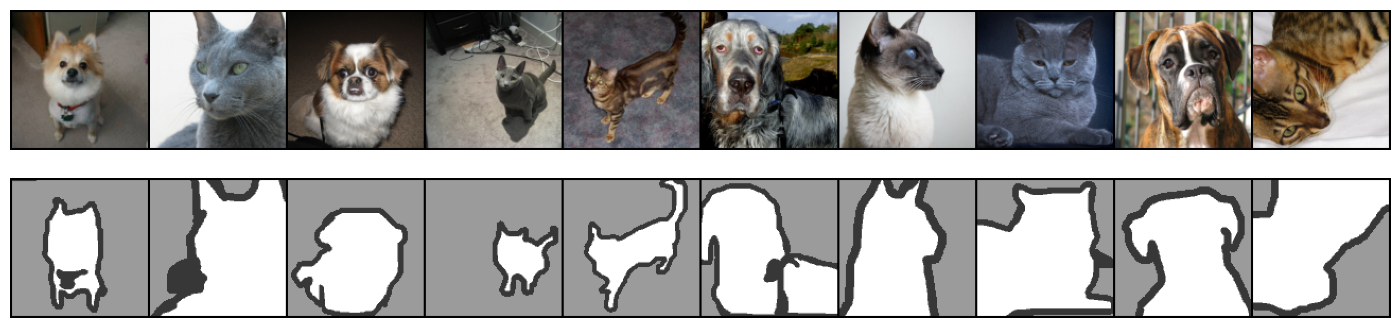

In [ ]:
imgs, segs = next(iter(dataloader))
fig,axes = plt.subplots(2,1, figsize=(20,4))
axes[0].axis('off')
axes[0].imshow(np.transpose(make_grid(imgs[:10], nrow=10, padding=2, normalize=True), (1,2,0)))
axes[1].axis('off')
axes[1].imshow(np.transpose(make_grid(255-100*segs[:10].unsqueeze(1),nrow=10, padding=2), (1,2,0)))
fig.show()

In [ ]:
# model

class Block(nn.Module):
  def __init__(self, in_hidden, out_hidden):
    super(Block, self).__init__()
    self.conv1 = nn.Conv2d(in_hidden, out_hidden, 3, 1, 1)
    self.conv2 = nn.Conv2d(out_hidden, out_hidden, 3, 1, 1)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    return x


class U_Net(nn.Module):
  def __init__(self, img_size, hidden_size):
    super(U_Net, self).__init__()
    self.block1 = Block(3, hidden_size)
    self.block2 = Block(hidden_size, 2*hidden_size)
    self.block3 = Block(2*hidden_size, 4*hidden_size)
    self.block4 = Block(4*hidden_size, 8*hidden_size)
    self.block5 = Block(8*hidden_size, 16*hidden_size)
    self.block6 = Block(16*hidden_size, 8*hidden_size)
    self.block7 = Block(8*hidden_size, 4*hidden_size)
    self.block8 = Block(4*hidden_size, 2*hidden_size)
    self.block9 = Block(2*hidden_size, hidden_size)

    self.pool = nn.MaxPool2d(2, 2)
    self.upconv1 = nn.ConvTranspose2d(16*hidden_size, 8*hidden_size, 2, 2, 0)
    self.upconv2 = nn.ConvTranspose2d(8*hidden_size, 4*hidden_size, 2, 2, 0)
    self.upconv3 = nn.ConvTranspose2d(4*hidden_size, 2*hidden_size, 2, 2, 0)
    self.upconv4 = nn.ConvTranspose2d(2*hidden_size, hidden_size, 2, 2, 0)
    self.conv = nn.Conv2d(hidden_size, 3, 1, 1, 0)
  def forward(self, x):
    x = self.block1(x)
    x1 = x
    x = self.block2(self.pool(x))
    x2 = x
    x = self.block3(self.pool(x))
    x3 = x
    x = self.block4(self.pool(x))
    x4 = x

    x = self.block5(self.pool(x))
    
    x = self.upconv1(x)
    x = self.block6(torch.cat([x4,x],dim=1))
    x = self.upconv2(x)
    x = self.block7(torch.cat([x3,x],dim=1))
    x = self.upconv3(x)
    x = self.block8(torch.cat([x2,x],dim=1))
    x = self.upconv4(x)
    x = self.block9(torch.cat([x1,x],dim=1))

    x = self.conv(x)
    return x 

In [ ]:
# ready for training

hidden_size = 64
lr = 0.02
momentum = 0.99

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = U_Net(img_size, hidden_size).to(device)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=momentum)
criterion = nn.CrossEntropyLoss(reduction='mean')

def PA(preds, segs):
  _, preds = preds.max(dim=1)
  # preds and segs : B x H x W
  b,h,w = preds.size()
  acc = preds.eq(segs).sum().item() / (b*h*w)
  return acc

def IoU(preds, segs):
  _, preds = preds.max(dim=1)
  # preds and segs : B x H x W
  preds_mask = torch.where(preds==0, 1, 0)
  segs_mask = torch.where(segs==0, 1, 0)
  iou = torch.sum(torch.logical_and(preds_mask, segs_mask), dim=(1,2)) \
  / (torch.sum(torch.logical_or(preds_mask, segs_mask), dim=(1,2)) + 1e-6)
  return torch.mean(iou).item()

In [ ]:
# training 50 epochs

n_epochs = 50
train_step = 0
print_interval = 50

for epoch in range(n_epochs):
  loss_epoch = 0
  PA_epoch = 0
  IoU_epoch = 0
  for imgs, segs in dataloader:
    imgs, segs = imgs.to(device), segs.to(device).type(torch.long)
    optimizer.zero_grad()    
    preds = model(imgs)
    loss = criterion(preds, segs)
    loss.backward()
    optimizer.step()

    train_step += 1
    loss_epoch += loss.item()
    PA_epoch += PA(preds, segs)
    IoU_epoch += IoU(preds, segs)

  print("[Epoch %2d] [Step %5d] [Loss %.4f] [PA %.2f] [IoU %.2f]"%(
          epoch+1, train_step, loss_epoch/len(dataloader),
          PA_epoch/len(dataloader), IoU_epoch/len(dataloader)))

[Epoch  1] [Step    29] [Loss 1.0250] [PA 0.47] [IoU 0.00]
[Epoch  2] [Step    58] [Loss 0.9878] [PA 0.51] [IoU 0.00]
[Epoch  3] [Step    87] [Loss 0.9731] [PA 0.51] [IoU 0.00]
[Epoch  4] [Step   116] [Loss 0.9725] [PA 0.51] [IoU 0.00]
[Epoch  5] [Step   145] [Loss 0.9633] [PA 0.51] [IoU 0.00]
[Epoch  6] [Step   174] [Loss 0.9376] [PA 0.52] [IoU 0.13]
[Epoch  7] [Step   203] [Loss 0.9109] [PA 0.54] [IoU 0.29]
[Epoch  8] [Step   232] [Loss 0.8994] [PA 0.56] [IoU 0.27]
[Epoch  9] [Step   261] [Loss 0.8974] [PA 0.56] [IoU 0.27]
[Epoch 10] [Step   290] [Loss 0.8918] [PA 0.55] [IoU 0.28]
[Epoch 11] [Step   319] [Loss 0.8758] [PA 0.57] [IoU 0.31]
[Epoch 12] [Step   348] [Loss 0.8650] [PA 0.58] [IoU 0.32]
[Epoch 13] [Step   377] [Loss 0.8605] [PA 0.59] [IoU 0.34]
[Epoch 14] [Step   406] [Loss 0.8323] [PA 0.62] [IoU 0.39]
[Epoch 15] [Step   435] [Loss 0.8002] [PA 0.65] [IoU 0.43]
[Epoch 16] [Step   464] [Loss 0.7803] [PA 0.66] [IoU 0.44]
[Epoch 17] [Step   493] [Loss 0.7530] [PA 0.68] [IoU 0.4

In [ ]:
# save

torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/코드 이론/model_save/unet50')

In [ ]:
# laod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 128
hidden_size = 64

model = U_Net(img_size, hidden_size).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/model_save/unet50'))

<All keys matched successfully>

In [ ]:
test_dataset = datasets.OxfordIIITPet('./', download=True,
                                 split='test', target_types='segmentation',
                                 transform = transforms.Compose([transforms.Resize(img_size),
                                                                 transforms.CenterCrop(img_size),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize([0.5,0.5,0.5,],
                                                                                      [0.5,0.5,0.5,])]),
                                 target_transform = transforms.Compose([transforms.Resize(img_size),
                                                                        transforms.CenterCrop(img_size),
                                                                        transforms.Lambda(lambda x : torch.tensor(np.array(x))-1 )]))
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

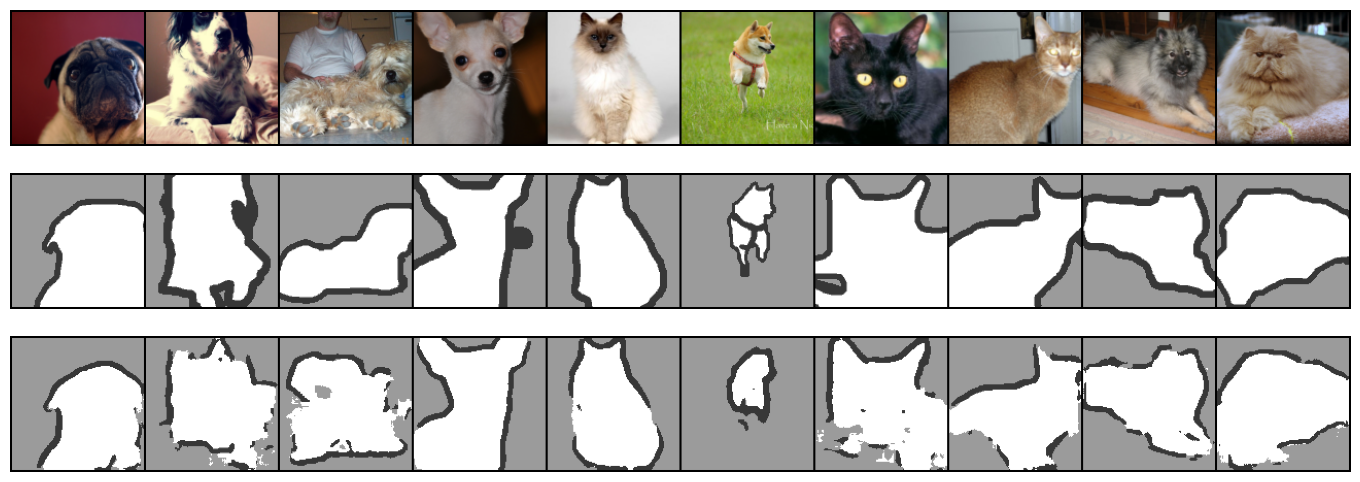

In [ ]:
with torch.no_grad():
  imgs, segs = next(iter(testloader))
  imgs, segs = imgs.to(device), segs.to(device).type(torch.long)
  preds = model(imgs)
  _, preds = preds.max(dim=1)

  fig,axes = plt.subplots(3,1, figsize=(20,6))
  axes[0].axis('off')
  axes[0].imshow(np.transpose(make_grid(imgs[:10].detach().cpu(), nrow=10, padding=2, normalize=True), (1,2,0)))
  axes[1].axis('off')
  axes[1].imshow(np.transpose(make_grid(255-100*segs[:10].detach().cpu().unsqueeze(1),nrow=10, padding=2), (1,2,0)))
  axes[2].axis('off')
  axes[2].imshow(np.transpose(make_grid(255-100*preds[:10].detach().cpu().unsqueeze(1),nrow=10, padding=2), (1,2,0)))
  fig.show()

In [ ]:
with torch.no_grad():
  loss_epoch = 0
  PA_epoch = 0
  IoU_epoch = 0
  for imgs, segs in testloader:
    imgs, segs = imgs.to(device), segs.to(device).type(torch.long)
    preds = model(imgs)
    PA_epoch += PA(preds, segs)
    IoU_epoch += IoU(preds, segs)

print('PA :', PA_epoch / len(testloader))
print('IoU :', IoU_epoch / len(testloader))

PA : tensor(0.8389, device='cuda:0')
IoU : 0.738394714634994


In [ ]:
from PIL import Image

s1 = Image.open('/content/drive/MyDrive/Colab Notebooks/코드 이론/Paper review/VQVAE/sample1.jpg')
s2 = Image.open('/content/drive/MyDrive/Colab Notebooks/코드 이론/Paper review/VQVAE/sample2.jpg')
s3 = Image.open('/content/drive/MyDrive/Colab Notebooks/코드 이론/Paper review/VQVAE/sample3.png')
r,g,b,a = s3.split()
s3 = Image.merge('RGB',(r,g,b))

x_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(128,transforms.InterpolationMode('nearest')),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
    lambda x : x.unsqueeze(0)])

s = [s1,s2,s3]
for i in range(3):
  s[i] = x_transform(s[i])

X = torch.cat(s, dim=0)
X.size()

torch.Size([3, 3, 128, 128])

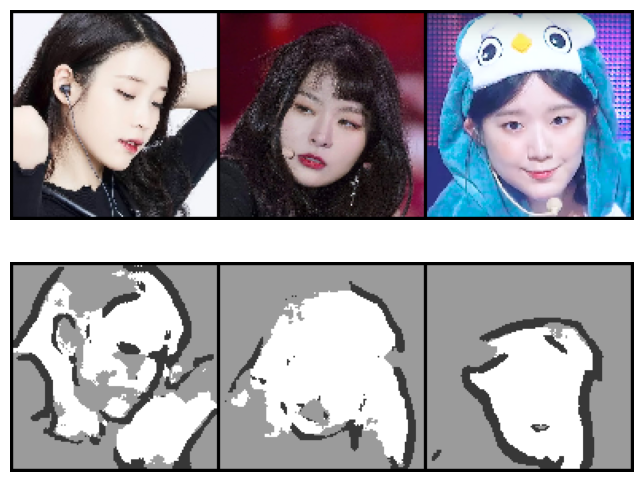

In [ ]:
with torch.no_grad():
  imgs = X.to(device)
  preds = model(imgs)
  _, preds = preds.max(dim=1)

  fig,axes = plt.subplots(2,1, figsize=(20,6))
  axes[0].axis('off')
  axes[0].imshow(np.transpose(make_grid(imgs[:10].detach().cpu(), nrow=10, padding=2, normalize=True), (1,2,0)))
  axes[1].axis('off')
  axes[1].imshow(np.transpose(make_grid(255-100*preds[:10].detach().cpu().unsqueeze(1),nrow=10, padding=2), (1,2,0)))
  fig.show()

### Cityscapes

### Encoder-Decoder

https://arxiv.org/pdf/1412.7062.pdf  
https://arxiv.org/pdf/2001.05566.pdf  

https://www.kaggle.com/code/tanmaypatil3151/pix2pix-pytorch-segmentation




In [ ]:
class City(Dataset):
  def __init__(self, dir, img_size):
    super(City, self).__init__()
    self.dir = dir
    self.files = os.listdir(dir)
    self.img_size = img_size
    self.len = len(self.files)
    self.img_trans = transforms.Compose([transforms.Resize(img_size),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.5,0.5,0.5,],
                                                              [0.5,0.5,0.5,])])
  def __getitem__(self, index):
    img = Image.open(self.dir+'/'+self.files[index])
    img = self.img_trans(img)
    img, seg = img[:,:,:self.img_size], img[:,:,self.img_size:]
    return img, seg

  def __len__(self):
    return self.len

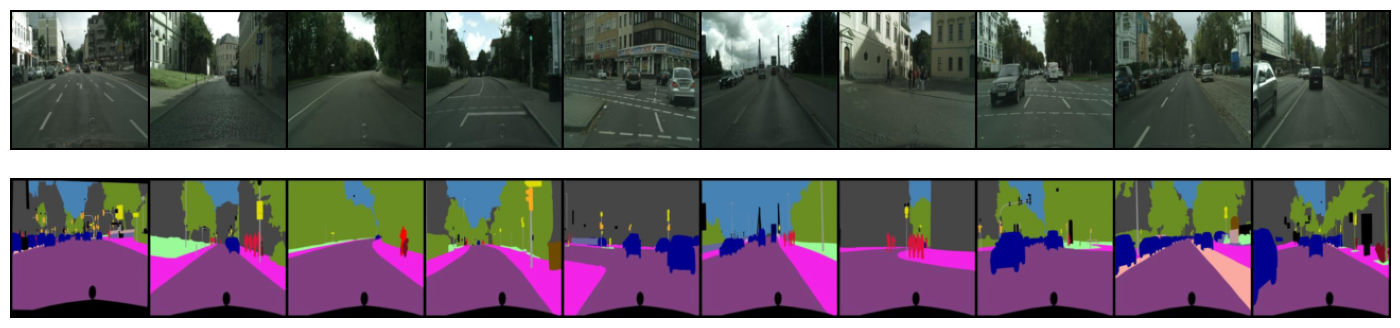

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/cityscapes/cityscapes_data/train'
city = City(train_dir, 128)
dataloader = DataLoader(city, batch_size=128)

imgs, segs = next(iter(dataloader))
fig,axes = plt.subplots(2,1, figsize=(20,4))
axes[0].axis('off')
axes[0].imshow(np.transpose(make_grid(imgs[:10], nrow=10, padding=2, normalize=True), (1,2,0)))
axes[1].axis('off')
axes[1].imshow(np.transpose(make_grid(segs[:10], nrow=10, padding=2, normalize=True), (1,2,0)))
fig.show()

### PASCAL VOC

In [ ]:
from torchvision.datasets import VOCSegmentation
voc = VOCSegmentation('/content/voc', year='2012', image_set='train',
                      download=True, transform=None, target_transform=None)

100%|██████████| 1999639040/1999639040 [01:46<00:00, 18728907.91it/s]


Extracting /content/voc/VOCtrainval_11-May-2012.tar to /content/voc


In [ ]:
len(voc)

1464

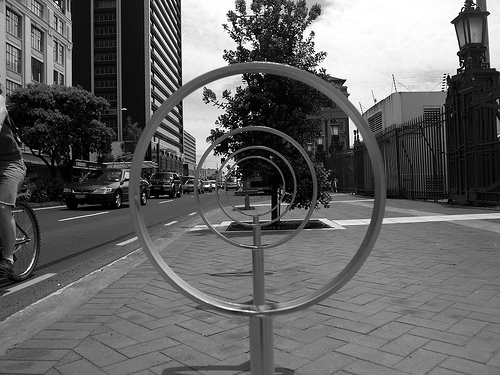

In [31]:
voc[16][0]

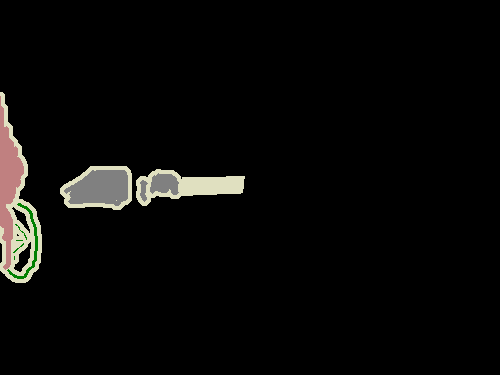

In [41]:
t = voc[16][1]
t

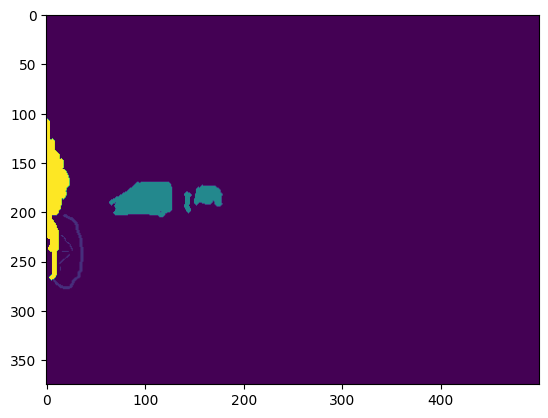

In [48]:
t = np.array(t)
tr = np.place(t, t==255, 0)
plt.imshow(t)

TypeError: ignored

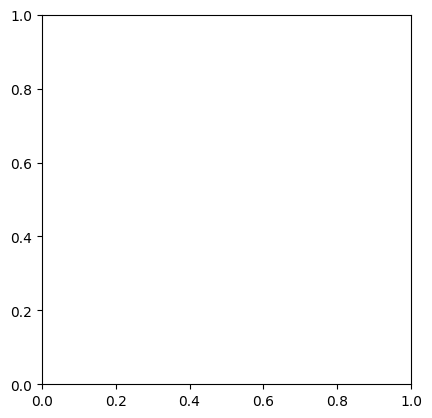

In [49]:
plt.imshow(tr)